In [198]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.ops.indexing import Vindex
import jax.numpy as jnp

assert numpyro.__version__.startswith("0.9.2")

import numpy as np
import scipy.stats as ss
import random as rand

## Generate Test Data

In [199]:
N=1000
heterozygosity = 0.045
alphabet = {"A":0, "C":1, "G":2, "T":3}
genotypes = {
    "AA":0, "AC":1, "AG":2, "AT":3, 
    "CA":1, "CC":4, "CG":5, "CT":6,
    "GA":2, "GC":4, "GG":7, "GT":8, 
    "TA":3, "TC":6, "TG":8, "TT":9,
}

snp_positions = np.sort(rand.sample(range(N),round(N*heterozygosity))) # [loc for i in range(round(N*heterozygosity))]
sequence = "".join(np.random.choice(list(alphabet.keys()), N))

print(f"Uniformly selected SNP loci:\n{snp_positions}")
print(f"\nReference sequence of randomly generated gene sequence:\n{sequence}")

Uniformly selected SNP loci:
[  6   7  90  91  99 134 142 151 156 185 222 235 240 286 289 304 314 348
 389 457 466 476 479 518 525 565 614 623 632 635 639 699 737 750 755 757
 777 828 928 962 971 978 981 997 998]

Reference sequence of randomly generated gene sequence:
CGTTGGGAGGTGTTGTGTGCTGTCGGCCGCCCGAACTAGCCCTCGCGGTCGCCGCGTCCCTTCCGTGAATGGCGACGGTCACCCAGGGACTATCGGCAAAGTTTATTCGAGGAAGTCGTACCGCAAACAATCTAATATCCCCCACACTCCATGTCCCGAGGGAAAAGTACAAGAGCGCCCATCGTAGGGCACCCGGCTTGAGCTCGGAACGACGGTTGGACGTCGTCAGATCCTCACTGTAGAACGTCTAACCATAAACCCGGTGGCTTCGGACACCTCCGGCTGCGCCGGCTGACCAGGCGTATTGCAGACGAGCTGCTATGAGAGGGCTGAATATGTATCGTTTAGATAACAGGATAATTGGTGGTACCACCTCAGGGTACCCTGGCGTAATTGTAGTGCCCTCCACTCTAAATGCACCAAATGGTCAGGAATCGTGCTCTAGCGGCGGCAGTCAGTGCGTATTCATTGAAAAACCCGTTGTTTCGTCAAGTGCGCCAGACGAGTTACTGCAACGAAACAATTCGCAGGTGTCTTTTGGTGCTGTAATGCGATCAGGGGTTCAGCGCTTTCCACACAATGAGAGATTCCCTGCCGCGTCACACTGAGAAGTAGAATAGAACCGTCCTTCGGGGGTCACCACCCAACATTCTGATATGAGTCTCCATATTCAGAGTCTAGCCATAACGCGAATCATGACGAGCTGACCAACATGTCTCTTTTGAGGATG

In [220]:
class EmbryoSequenceSimulator:
    def __init__(self, references, snps, n_embryos):
        self.references = references # map gene->sequence
        self.snps = snps # map gene->list of snp locations
        self.n_embryos = n_embryos
        
        # Number of cells that can be harvested from embryo
        self.n_cells = 5
        self.alphabet = {"A":0, "C":1, "G":2, "T":3}

    def pooled_snp_profile_simulation(self):
        profile = []
        for _ in range(self.n_embryos):
            snp_profile = []
            for gene in self.references.keys():
                sequence = self.references[gene]
                snp_positions = self.snps[gene]
                m_chromatid,p_chromatid = self.embryo_sequence_simulation(sequence, snp_positions)
                for locus in snp_positions:
                    genotype = "".join([m_chromatid[locus],p_chromatid[locus]])
                    snp_profile.append(genotypes[genotype])
            for __ in range(self.n_cells):
                profile.append(snp_profile)
        return profile

    def embryo_sequence_simulation(self, reference, snp_positions):

        # Seeding parental chromatids
        parental_seqs = self.parental_seeding(reference, snp_positions)

        # Homologous recombination
        m0,m1 = self.homologous_recombination(parental_seqs["m0"],parental_seqs["m1"])
        p0,p1 = self.homologous_recombination(parental_seqs["p0"],parental_seqs["p1"])

        # Choose pairs of parental chromatids that get inherited by embryo
        m_chromatid = m0 if rand.random() <= 0.5 else m1
        p_chromatid = p0 if rand.random() <= 0.5 else p1

        return m_chromatid, p_chromatid

    def parental_seeding(self, reference, snp_positions):
        sequences = {}
        for parent in ["m0", "m1", "p0", "p1"]: # m = maternal; p = paternal
            # key: position; value: random nucleotide
            snp_profile = {locus:rand.choice(list(self.alphabet.keys())) for locus in snp_positions}
            sequence = [char for char in reference]
            for locus,char in snp_profile.items():
                sequence[locus] = char
            sequences[parent] = "".join(sequence)
        return sequences

    def homologous_recombination(self, c0, c1): # c for chromatid
        chiasma_point = rand.choice(range(len(c0)))

        # Maybe not necessary, but intent is that either top or bottom half can cross over 
        if rand.random() <= 0.5:
            updated_c0 = c0[:chiasma_point]+c1[chiasma_point:]
            updated_c1 = c1[:chiasma_point]+c0[chiasma_point:]
        else:
            updated_c0 = c1[:chiasma_point]+c0[chiasma_point:]
            updated_c1 = c0[:chiasma_point]+c1[chiasma_point:]

        return updated_c0, updated_c1        

In [221]:
heterozygosity = 0.045
alphabet = {"A":0, "C":1, "G":2, "T":3}
genotypes = {
    "AA":0, "AC":1, "AG":2, "AT":3, 
    "CA":1, "CC":4, "CG":5, "CT":6,
    "GA":2, "GC":4, "GG":7, "GT":8, 
    "TA":3, "TC":6, "TG":8, "TT":9,
}

In [222]:
# Model for multiple genes
sequences = {} # key: gene/contig identifer;  value: nucleotide sequence
snps = {}      # key: gene/contig identifier; value: list of snp locations

for gene in ["gene1", "gene2"]:
    N = round(np.random.normal(1000, 250)) # gene length
    snps[gene] = np.sort(rand.sample(range(N),round(N*heterozygosity))) # [loc for i in range(round(N*heterozygosity))]
    sequences[gene] = "".join(np.random.choice(list(alphabet.keys()), N))

n_embryos = 2
simulator = EmbryoSequenceSimulator(sequences,snps,n_embryos)
profile = simulator.pooled_snp_profile_simulation()
X = np.array(profile)
print(X.shape)
print(X)

(10, 86)
[[7 3 1 0 5 8 4 4 4 6 9 8 2 0 6 3 8 8 6 4 5 6 8 8 9 2 7 1 7 2 3 2 0 4 4 4
  9 2 1 2 2 0 8 6 6 1 1 8 7 0 4 6 5 3 9 3 4 4 6 6 4 6 8 9 8 4 1 2 1 3 8 0
  8 6 2 6 1 7 7 8 1 2 4 3 0 4]
 [7 3 1 0 5 8 4 4 4 6 9 8 2 0 6 3 8 8 6 4 5 6 8 8 9 2 7 1 7 2 3 2 0 4 4 4
  9 2 1 2 2 0 8 6 6 1 1 8 7 0 4 6 5 3 9 3 4 4 6 6 4 6 8 9 8 4 1 2 1 3 8 0
  8 6 2 6 1 7 7 8 1 2 4 3 0 4]
 [7 3 1 0 5 8 4 4 4 6 9 8 2 0 6 3 8 8 6 4 5 6 8 8 9 2 7 1 7 2 3 2 0 4 4 4
  9 2 1 2 2 0 8 6 6 1 1 8 7 0 4 6 5 3 9 3 4 4 6 6 4 6 8 9 8 4 1 2 1 3 8 0
  8 6 2 6 1 7 7 8 1 2 4 3 0 4]
 [7 3 1 0 5 8 4 4 4 6 9 8 2 0 6 3 8 8 6 4 5 6 8 8 9 2 7 1 7 2 3 2 0 4 4 4
  9 2 1 2 2 0 8 6 6 1 1 8 7 0 4 6 5 3 9 3 4 4 6 6 4 6 8 9 8 4 1 2 1 3 8 0
  8 6 2 6 1 7 7 8 1 2 4 3 0 4]
 [7 3 1 0 5 8 4 4 4 6 9 8 2 0 6 3 8 8 6 4 5 6 8 8 9 2 7 1 7 2 3 2 0 4 4 4
  9 2 1 2 2 0 8 6 6 1 1 8 7 0 4 6 5 3 9 3 4 4 6 6 4 6 8 9 8 4 1 2 1 3 8 0
  8 6 2 6 1 7 7 8 1 2 4 3 0 4]
 [1 1 3 9 7 2 4 1 2 3 4 1 3 2 8 7 6 4 3 8 6 2 6 8 8 9 2 1 9 8 5 4 5 5 1 4
  0 5 3 1 0 4 3 4 4 7 

## Implement Model

In [223]:
S = 10 # The number of possible states
states = [['A','A'], ['A','C'], ['A','G'], ['A','T'], ['C','C'], ['C','G'], ['C','T'], ['G','G'], ['G','T'], ['T','T']]

K = 2 # Number of embryos
kappa = np.ones(K) # The prior on pi

gamma = []

# Set the gamma prior
# Single allele states have most of the weight in the true state
# Two allele states have the weight distributed between the true state and the single allele versions
for i in range(len(states)):
    weights = 0.1*np.ones(S)
    
    cur_state = states[i]
    
    if cur_state[0] == cur_state[1]:
        weights[i] = 10
    else:
        for j in range(len(states)):
            is_first_allele = (states[j][0] == cur_state[0] and states[j][1] == cur_state[0])
            is_second_allele =  (states[j][0] == cur_state[1] and states[j][1] == cur_state[1])
            
            if  is_first_allele or is_second_allele:
                weights[j] = 10
        
        weights[i] = 10
        
    gamma.append(weights)
                
gamma = jnp.array(gamma)

In [224]:
def sc_genotyper(S, kappa, gamma, K, X):
    # Sample pi from prior
    pi = numpyro.sample('pi', dist.Dirichlet(kappa))
        
    # Sample epsilon from prior
    with numpyro.plate('S', S) as s:
        epsilon = numpyro.sample('epsilon', dist.Dirichlet(gamma[s]))
            
    num_cells = X.shape[0]
    num_loci = X.shape[1]
    
    # Sample G from prior
    with numpyro.plate('K', K):
        with numpyro.plate('M', num_loci):
            G = numpyro.sample('G', dist.Categorical(1/S*jnp.ones(S)))
        
    with numpyro.plate('N', num_cells, dim=-2):
        Z_n = numpyro.sample('Z_n', dist.Categorical(pi))
        
        with numpyro.plate('M', num_loci, dim=-1) as m:
            v = Vindex(G)[Z_n, m]
            e = Vindex(epsilon)[v]
            
            numpyro.sample('X_{nm}', dist.Categorical(e), obs=X)

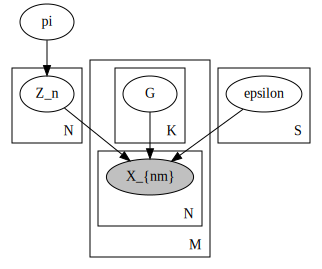

In [225]:
numpyro.render_model(sc_genotyper, model_args=(S, kappa, gamma, K, X))

In [226]:
from jax import random
from numpyro.infer import MCMC, NUTS
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS

nuts_kernel = NUTS(sc_genotyper)
kernel = DiscreteHMCGibbs(nuts_kernel)
mcmc = MCMC(kernel, num_warmup=2000, num_samples=10000)
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, S, kappa, gamma, K, X)

sample: 100%|██████████| 12000/12000 [06:25<00:00, 31.16it/s, 1023 steps of size 1.24e-02. acc. prob=0.83]


In [218]:
mcmc.print_summary()  


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      G[0,0]      4.27      2.25      4.00      0.00      8.00   8666.71      1.00
      G[0,1]      5.55      2.52      7.00      0.00      8.00    158.53      1.02
      G[1,0]      4.20      1.86      4.00      0.00      7.00   8295.20      1.00
      G[1,1]      6.04      2.15      7.00      0.00      7.00    109.28      1.03
      G[2,0]      4.55      2.88      5.00      0.00      9.00  10024.17      1.00
      G[2,1]      4.53      2.86      5.00      1.00      9.00   9899.85      1.00
      G[3,0]      4.50      2.87      4.00      0.00      8.00  10115.84      1.00
      G[3,1]      4.49      2.87      4.00      0.00      8.00  10002.24      1.00
      G[4,0]      4.55      2.87      5.00      1.00      9.00   9720.17      1.00
      G[4,1]      4.50      2.88      4.00      0.00      9.00   9480.53      1.00
      G[5,0]      4.53      2.88      5.00      0.00      9.00  10129.44      1.00
   

In [229]:
# Note that a single cluster solution seems to get sampled
# from almost as often as the two cluster solution
mcmc.get_samples()['Z_n']

DeviceArray([[[1],
              [1],
              [1],
              ...,
              [0],
              [0],
              [0]],

             [[1],
              [1],
              [1],
              ...,
              [0],
              [0],
              [0]],

             [[1],
              [1],
              [1],
              ...,
              [0],
              [0],
              [0]],

             ...,

             [[1],
              [1],
              [1],
              ...,
              [1],
              [1],
              [1]],

             [[1],
              [1],
              [1],
              ...,
              [1],
              [1],
              [1]],

             [[1],
              [1],
              [1],
              ...,
              [1],
              [1],
              [1]]], dtype=int32)